In [1]:
import os
from datetime import datetime

import pandas as pd
import matplotlib
import seaborn as sns

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

# Preparing data

In [3]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [4]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [5]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [6]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords.sort()

In [7]:
print(keywords)

['Beam me up,\\? Scotty', 'Chekhov', 'Crusher', 'Delta Vega', 'Highly illogical', 'I have been and always shall be your friend', "I'm a doctor,\\? not a", "I'm giving her all she's got,\\? Captain", 'KHAAA\\+N', 'Kirk', 'Klingon', 'Kobayashi Maru', 'LLAP', 'Live long and prosper', 'McCoy', 'Nero', 'Nuclear wessels', 'Nurse Chapel', 'Orion', 'Picard', 'Pike', 'Prime Directive', 'Resistance is futile', 'Romulan', 'Romulan Narada', 'Sarek', 'Scotty', 'Set phasers to stun', 'Space,\\? The Final Frontier', 'Spock', 'Star Trek', 'Star fleet', 'Stardate', 'Starship Enterprise', 'Sulu', 'The needs of the many outweigh the needs of the few', 'Transporter beam', 'Uhura', 'Vulcan', 'Vulcan Salute', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'to boldly go where no man has gone before']


In [9]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': str,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': str,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna('')

CPU times: user 29.1 s, sys: 1.28 s, total: 30.4 s
Wall time: 30.4 s


In [10]:
len(reddit_df)

2669814

In [11]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Subreddits

In [12]:
reddit_df['subreddit'].value_counts()

AdviceAnimals           216848
startrek                182534
AskReddit               179550
fantasyfootball          92045
movies                   65545
nfl                      62410
Smite                    58973
DaystromInstitute        57314
sto                      44103
funny                    37788
doctorwho                35282
pics                     35054
scifi                    33434
Planetside               27387
todayilearned            25934
GlobalOffensiveTrade     25360
motorcycles              24585
SquaredCircle            20231
Civcraft                 19555
IAmA                     18502
gaming                   18339
atheism                  18110
grandorder               16730
chicagobulls             16501
videos                   16271
nba                      16193
PercyJacksonRP           15635
CFB                      15368
WTF                      13752
TheDescendantsOfRome     13213
                         ...  
OctagonHelmets               1
interfai

In [19]:
total_lines_sr = pd.Series(total_lines)

In [20]:
total_lines_sr.sum()

2578531512

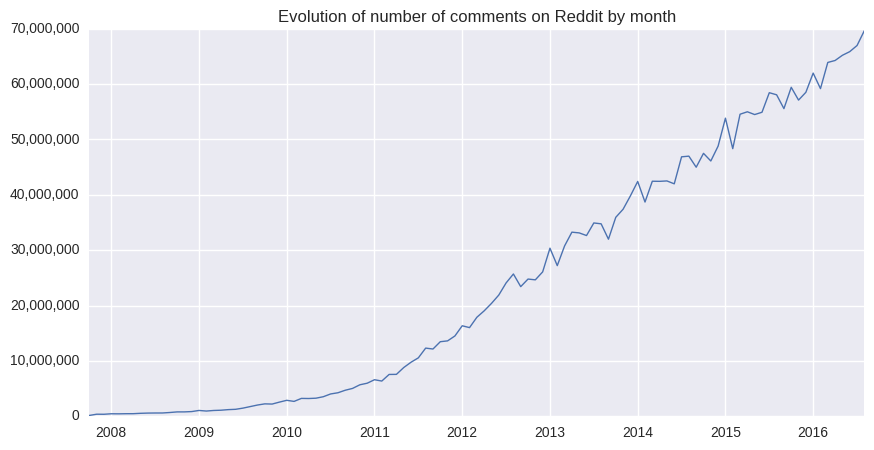

In [21]:
ax = total_lines_sr.plot(
    figsize=(10,5),
    title='Evolution of number of comments on Reddit by month',
)
ax.get_yaxis().get_major_formatter().set_scientific(False)
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)

## Star Trek

In [22]:
valid_dates = pd.date_range('2007-10-1', '2016-08-31', freq='MS')

In [23]:
peaks1 = ['2007-10-01', '2009-05-01', '2010-01-01', '2011-01-01', '2012-09-01', '2013-01-01', '2013-05-01', '2013-12-01',
         '2014-10-01', '2015-03-01', '2015-10-01', '2015-12-01', '2016-07-01',]
peaks1 = list(map(pd.lib.Timestamp, peaks1))

In [24]:
show_dates1 = [x.strftime('%Y %b') if x in peaks1 else '' for x in valid_dates]

In [25]:
reddit_by_month = reddit_df.groupby('month')['id'].count()

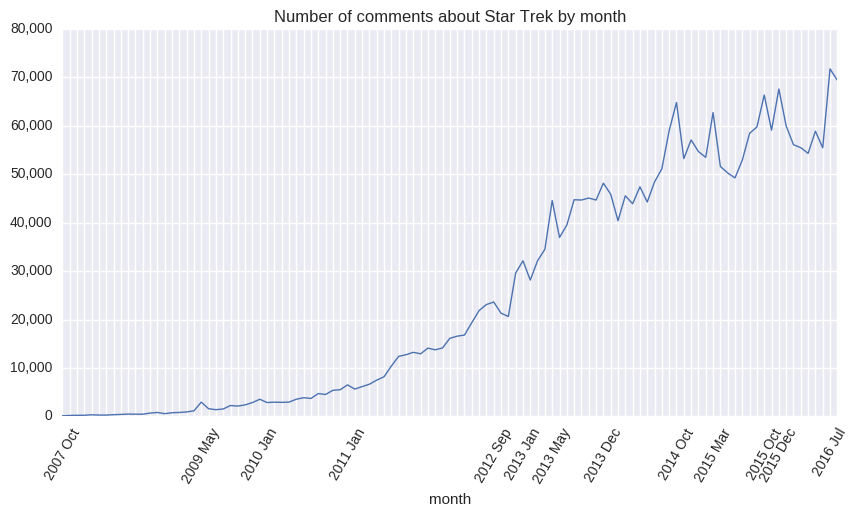

In [39]:
ax = reddit_by_month.plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=reddit_by_month.index,
    rot=60,
    title='Number of comments about Star Trek by month',
)
ax.set_xticklabels(show_dates1);
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
ax.get_yaxis().set_major_formatter(formatter)

In [40]:
comparison_df = pd.DataFrame({'Star Trek': reddit_by_month.values, 'Total Reddit': total_lines_sr})

In [42]:
comparison_df['Proportion (%)'] = comparison_df.apply(
    lambda x: 100 * x['Star Trek'] / x['Total Reddit'], axis=1)

In [43]:
comparison_df.head()

,Star Trek,Total Reddit,Proportion (%)
2007-10-01,119,150429,0.079107
2007-11-01,190,372983,0.050941
2007-12-01,222,363390,0.061091
2008-01-01,235,452990,0.051878
2008-02-01,328,441768,0.074247


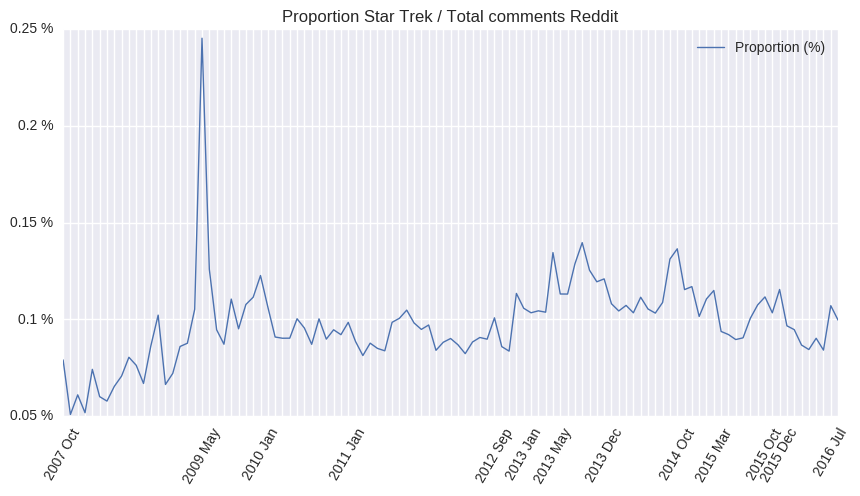

In [44]:
ax = comparison_df[['Proportion (%)']].plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=comparison_df.index,
    rot=60,
    title='Proportion Star Trek / Total comments Reddit',)
ax.set_xticklabels(show_dates1);
formatter = matplotlib.ticker.FuncFormatter(lambda x, p: format(str(x) + ' %'))
ax.get_yaxis().set_major_formatter(formatter)

### Keywords

In [45]:
%%time

vulcan_salute_df = reddit_df[reddit_df['body'].str.contains('Vulcan Salute', case=False)]

CPU times: user 20.9 s, sys: 179 µs, total: 20.9 s
Wall time: 20.8 s


In [46]:
len(vulcan_salute_df)

1612

In [52]:
peaks2 = ['2008-11-01', '2015-02-01',]
peaks2 = list(map(pd.lib.Timestamp, peaks2))

In [53]:
show_dates2 = [x.strftime('%Y %b') if x in peaks2 else '' for x in valid_dates]

In [54]:
vulcan_salute_by_month = vulcan_salute_df.groupby('month')['id'].count()

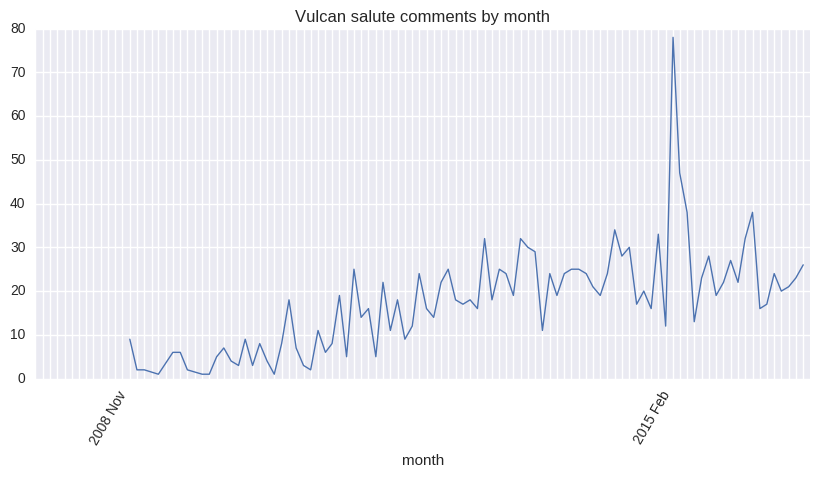

In [55]:
ax = vulcan_salute_by_month.plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=valid_dates,
    rot=60,
    title='Vulcan salute comments by month',
)
ax.set_xticklabels(show_dates2);

In [71]:
s = ''
for x in vulcan_salute_df['body']:
    s += x + ' '

In [74]:
q=nltk.word_tokenize(s)

In [75]:
from collections import Counter

In [76]:
c=Counter(q)

In [78]:
c.most_common(10)

[('.', 5578),
 ('-', 4826),
 ('the', 4634),
 (',', 4251),
 ('I', 2929),
 ('and', 2487),
 ('a', 2350),
 ('to', 2140),
 ('of', 1646),
 ('Vulcan', 1357)]

In [ ]:
khaaan_df = reddit_df[reddit_df['body'].str.contains('Khaaa+n', case=False)]

In [ ]:
len(khaaan_df)

In [ ]:
peaks3 = ['2009-01-01', '2011-03-01', '2011-12-01', '2013-05-01', '2013-10-01', '2016-07-01',]
peaks3 = list(map(pd.lib.Timestamp, peaks3))

In [ ]:
show_dates3 = [x.strftime('%Y %b') if x in peaks3 else '' for x in valid_dates]

In [ ]:
khaaan_df_by_month = khaaan_df.groupby('month')['id'].count()

In [ ]:
ax = khaaan_df_by_month.plot(
    figsize=(10,5),
    xlim=('2007-10-01', '2016-08-31'),
    xticks=khaaan_df_by_month.index,
    rot=60,
    title='Khaaan! comments by month',
)
ax.set_xticklabels(show_dates3);